<a href="https://colab.research.google.com/github/JhulianaM/Mammography/blob/master/edsrTuningPeqx4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Sube el archivo kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/mias-mammography
!unzip mias-mammography.zip -d mias

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/mias-mammography
License(s): other
 97% 302M/312M [00:02<00:00, 152MB/s]
100% 312M/312M [00:02<00:00, 150MB/s]
Archive:  mias-mammography.zip
  inflating: mias/Info.txt           
  inflating: mias/all-mias.tar.gz    
  inflating: mias/all-mias/Info.txt  
  inflating: mias/all-mias/Licence.txt  
  inflating: mias/all-mias/README    
  inflating: mias/all-mias/mdb001.pgm  
  inflating: mias/all-mias/mdb002.pgm  
  inflating: mias/all-mias/mdb003.pgm  
  inflating: mias/all-mias/mdb004.pgm  
  inflating: mias/all-mias/mdb005.pgm  
  inflating: mias/all-mias/mdb006.pgm  
  inflating: mias/all-mias/mdb007.pgm  
  inflating: mias/all-mias/mdb008.pgm  
  inflating: mias/all-mias/mdb009.pgm  
  inflating: mias/all-mias/mdb010.pgm  
  inflating: mias/all-mias/mdb011.pgm  
  inflating: mias/all-mias/mdb012.pgm  
  inflating: mias/all-mias/mdb013.pgm  
  inflating: mias/all-mias/mdb014.pgm  
  inflating: mias/a

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio de imágenes
data_dir = "mias/all-mias/"

# Cargar y preprocesar imágenes
images = []
for file_name in os.listdir(data_dir):
    if file_name.endswith('.pgm'):
        img_path = os.path.join(data_dir, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images.append(img)

# Normalización
images = np.array(images)
images = images.astype('float32') / 255.0

# Convertir imágenes en escala de grises a imágenes RGB
images_rgb = [np.stack((img,)*3, axis=-1) for img in images]


In [61]:
target_shape_hr = (128, 128)
target_shape_lr = (32, 32)
train_images_resized = [cv2.resize(img, target_shape_hr) for img in images_rgb]

In [62]:
# Dividir en conjuntos de entrenamiento, validación y prueba
train_images, test_images = train_test_split(train_images_resized, test_size=0.1, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)


In [63]:
# Redimensionar las imágenes de baja resolución
train_images_lr = [cv2.resize(img, target_shape_lr) for img in train_images]
val_images_lr = [cv2.resize(img, target_shape_lr) for img in val_images]

In [64]:
# Convertir a formato de tensor y asegurar que las formas son correctas
train_images_lr = np.array(train_images_lr)
val_images_lr = np.array(val_images_lr)
train_images = np.array(train_images)
val_images = np.array(val_images)

print(f"Forma de train_images_lr: {train_images_lr.shape}")
print(f"Forma de train_images: {train_images.shape}")

Forma de train_images_lr: (260, 32, 32, 3)
Forma de train_images: (260, 128, 128, 3)


In [65]:
# Crear generadores de datos con data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [66]:
train_generator = train_datagen.flow(train_images_lr, train_images, batch_size=16)
val_generator = val_datagen.flow(val_images_lr, val_images, batch_size=16)

In [34]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation

In [67]:
# Crear un modelo más complejo pero no demasiado pesado
input_layer = Input(shape=(target_shape_lr[0], target_shape_lr[1], 3))
x = UpSampling2D(size=(4, 4))(input_layer)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
output_layer = Conv2D(3, (3, 3), padding='same')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [68]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

In [69]:
# Entrenar el modelo usando generadores
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,  # Incrementar el número de épocas para mejorar el entrenamiento
                    steps_per_epoch=len(train_images_lr)//16,
                    validation_steps=len(val_images_lr)//16)

Epoch 1/20
16/16 [==============================] - 3s 68ms/step - loss: 0.4254 - val_loss: 0.1251
Epoch 2/20
16/16 [==============================] - 1s 46ms/step - loss: 0.1775 - val_loss: 0.1271
Epoch 3/20
16/16 [==============================] - 1s 42ms/step - loss: 0.1183 - val_loss: 0.1274
Epoch 4/20
16/16 [==============================] - 1s 43ms/step - loss: 0.0967 - val_loss: 0.1257
Epoch 5/20
16/16 [==============================] - 1s 42ms/step - loss: 0.0884 - val_loss: 0.1243
Epoch 6/20
16/16 [==============================] - 1s 41ms/step - loss: 0.0821 - val_loss: 0.1267
Epoch 7/20
16/16 [==============================] - 1s 42ms/step - loss: 0.0814 - val_loss: 0.1390
Epoch 8/20
16/16 [==============================] - 1s 44ms/step - loss: 0.0806 - val_loss: 0.1258
Epoch 9/20
16/16 [==============================] - 1s 42ms/step - loss: 0.0772 - val_loss: 0.1274
Epoch 10/20
16/16 [==============================] - 1s 42ms/step - loss: 0.0748 - val_loss: 0.1320
Epoch 11/

In [70]:
# Guardar el modelo ajustado
model.save('edsr_fine_tuned2.h5')

In [72]:
print(f"Forma de train_images_lr: {train_images_lr.shape}")
print(f"Forma de train_images: {train_images.shape}")

Forma de train_images_lr: (260, 32, 32, 3)
Forma de train_images: (260, 128, 128, 3)


In [71]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(test_images_lr, test_images)
print(f'Test Loss: {test_loss}')

ValueError: Data cardinality is ambiguous:
  x sizes: 33
  y sizes: 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128
Make sure all arrays contain the same number of samples.

In [58]:
# Realizar predicciones en el conjunto de prueba
predicted_images = model.predict(test_images_lr)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_6" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 16, 16, 3)


otro

In [3]:
# Redimensionar las imágenes a una resolución menor para ajustar el uso de memoria
target_shape = (64, 64)
train_images_resized = [cv2.resize(img, target_shape) for img in images_rgb]

# Dividir en conjuntos de entrenamiento, validación y prueba
train_images, test_images = train_test_split(train_images_resized, test_size=0.1, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

# Redimensionar las imágenes de baja resolución
train_images_lr = [cv2.resize(img, (target_shape[0]//4, target_shape[1]//4)) for img in train_images]
val_images_lr = [cv2.resize(img, (target_shape[0]//4, target_shape[1]//4)) for img in val_images]

# Convertir a formato de tensor y asegurar que las formas son correctas
train_images_lr = np.array(train_images_lr)
val_images_lr = np.array(val_images_lr)
train_images = np.array(train_images)
val_images = np.array(val_images)

print(f"Forma de train_images_lr: {train_images_lr.shape}")
print(f"Forma de train_images: {train_images.shape}")

Forma de train_images_lr: (260, 16, 16, 3)
Forma de train_images: (260, 64, 64, 3)


In [4]:
# Crear generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_images_lr, train_images, batch_size=16)
val_generator = val_datagen.flow(val_images_lr, val_images, batch_size=16)


In [9]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D

In [13]:
# Crear un modelo que convierte imágenes de 16x16 a 64x64
input_layer = Input(shape=(target_shape[0]//4, target_shape[1]//4, 3))
x = UpSampling2D(size=(4, 4))(input_layer)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
output_layer = Conv2D(3, (3, 3), padding='same')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [14]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

In [24]:
# Entrenar el modelo usando generadores
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    steps_per_epoch=len(train_images_lr)//16,
                    validation_steps=len(val_images_lr)//16)

Epoch 1/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0711 - val_loss: 0.0693
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0692 - val_loss: 0.0648
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0671 - val_loss: 0.0650
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0643 - val_loss: 0.0625
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0612 - val_loss: 0.0560
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0578 - val_loss: 0.0561
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0538 - val_loss: 0.0479
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0494 - val_loss: 0.0467
Epoch 9/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0447 - val_loss: 0.0392
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0392 - val_loss: 0.0350
Epoch 11/50
1

In [22]:
# Guardar el modelo ajustado
model.save('edsr_fine_tuned.h5')

In [25]:
# Evaluar el modelo en el conjunto de prueba
test_images_lr = [cv2.resize(img, (target_shape[0]//4, target_shape[1]//4)) for img in test_images]
test_images_lr = np.array(test_images_lr)
test_images = np.array(test_images)

In [26]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(test_images_lr, test_images)
print(f'Test Loss: {test_loss}')

2/2 [==============================] - 0s 7ms/step - loss: 4505.2329
Test Loss: 4505.23291015625


In [19]:
# Realizar predicciones en el conjunto de prueba
predicted_images = model.predict(test_images_lr)

2/2 [==============================] - 0s 7ms/step


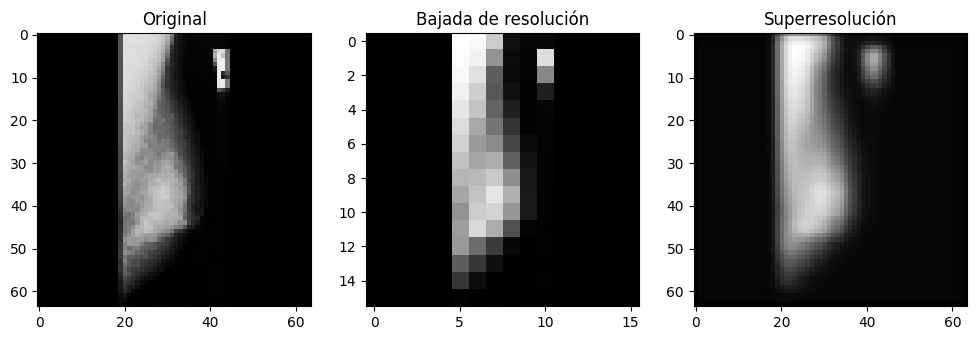

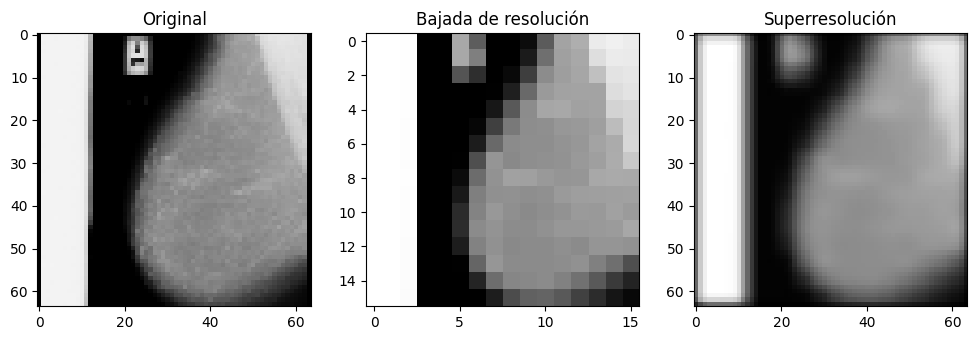

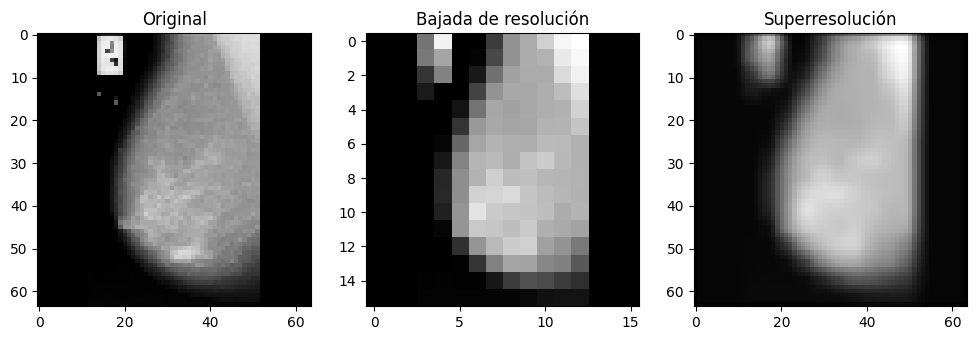

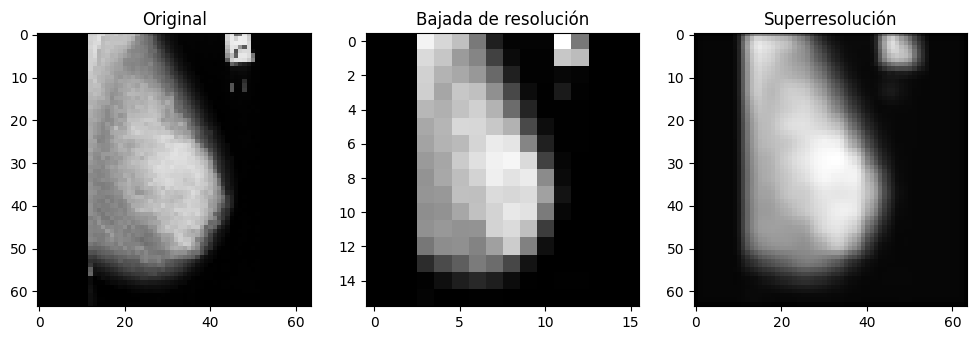

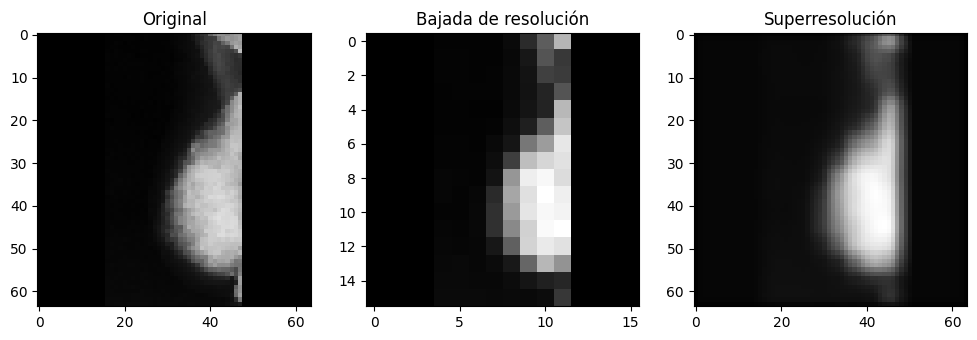

In [20]:
# Visualizar algunas imágenes de prueba y sus predicciones
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(test_images[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Bajada de resolución')
    plt.imshow(cv2.cvtColor(test_images_lr[i], cv2.COLOR_BGR2GRAY), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Superresolución')
    plt.imshow(cv2.cvtColor(predicted_images[i], cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.show()

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Directorio de imágenes
data_dir = "mias/all-mias/"

# Cargar y preprocesar imágenes
images = []
for file_name in os.listdir(data_dir):
    if file_name.endswith('.pgm'):
        img_path = os.path.join(data_dir, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images.append(img)

# Normalización
images = np.array(images)
images = images.astype('float32') / 255.0

# Convertir imágenes en escala de grises a imágenes RGB
images_rgb = [np.stack((img,)*3, axis=-1) for img in images]

# Dividir en conjuntos de entrenamiento, validación y prueba
train_images, test_images = train_test_split(images_rgb, test_size=0.1, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

# Redimensionar imágenes para entrenamiento (usando reducción de resolución)
train_images_lr = [cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)) for img in train_images]
val_images_lr = [cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)) for img in val_images]

train_images_lr = np.array(train_images_lr)
val_images_lr = np.array(val_images_lr)

train_images = np.array(train_images)
val_images = np.array(val_images)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Descargar y cargar el modelo EDSR preentrenado (suponiendo que el modelo esté disponible en un repositorio)
!git clone https://github.com/Saafke/EDSR_Tensorflow.git
%cd EDSR_Tensorflow

Cloning into 'EDSR_Tensorflow'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 149 (delta 1), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (149/149), 162.50 MiB | 21.19 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/EDSR_Tensorflow


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

# Cargar el modelo preentrenado
def load_edsr_model(model_path):
    with tf.io.gfile.GFile(model_path, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    session = tf.compat.v1.Session(graph=tf.Graph())
    with session.graph.as_default():
        tf.import_graph_def(graph_def, name="")
    return session

model_path = '/content/EDSR_Tensorflow/models/EDSR_x4.pb'
session = load_edsr_model(model_path)

# Obtener las capas del modelo preentrenado
input_tensor = session.graph.get_tensor_by_name("IteratorGetNext:0")
output_tensor = session.graph.get_tensor_by_name("NCHW_output:0")

# Construir un modelo Keras basado en el modelo preentrenado
input_layer = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
output_layer = Conv2D(3, (3, 3), padding='same')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(train_images_lr, train_images,
                    validation_data=(val_images_lr, val_images),
                    epochs=10,
                    batch_size=16)

# Guardar el modelo ajustado
model.save('edsr_fine_tuned.h5')

In [ ]:
# Redimensionar imágenes de prueba para evaluación
test_images_lr = [cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)) for img in test_images]
test_images_lr = np.array(test_images_lr)
test_images = np.array(test_images)

# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(test_images_lr, test_images)
print(f'Test Loss: {test_loss}')

# Realizar predicciones en el conjunto de prueba
predicted_images = model.predict(test_images_lr)

# Visualizar algunas imágenes de prueba y sus predicciones
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(test_images[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Bajada de resolución')
    plt.imshow(cv2.cvtColor(test_images_lr[i], cv2.COLOR_BGR2GRAY), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Superresolución')
    plt.imshow(cv2.cvtColor(predicted_images[i], cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.show()


In [ ]:
# Redimensionar imágenes de prueba para evaluación
test_images_lr = [cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)) for img in test_images]
test_images_lr = np.array(test_images_lr)
test_images = np.array(test_images)

# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(test_images_lr, test_images)
print(f'Test Loss: {test_loss}')

# Realizar predicciones en el conjunto de prueba
predicted_images = model.predict(test_images_lr)

# Visualizar algunas imágenes de prueba y sus predicciones
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(test_images[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Bajada de resolución')
    plt.imshow(cv2.cvtColor(test_images_lr[i], cv2.COLOR_BGR2GRAY), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Superresolución')
    plt.imshow(cv2.cvtColor(predicted_images[i], cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.show()
